数据集：Microsoft 资讯推荐 https://learn.microsoft.com/zh-cn/azure/open-datasets/dataset-microsoft-news?tabs=azureml-opendatasets
获取数据集

In [35]:
import os
import tempfile
import shutil
import urllib
import zipfile
import pandas as pd
from efficient_apriori import apriori
import apyori
# import json
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
os.makedirs(temp_dir, exist_ok=True)

# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'
def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        # url_as_filename = "MINDsmall_dev.zip"
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename
# For demonstration purpose, we will use small version validation set only.
# This file is about 30MB.
zip_path = download_url(validation_small_url, verbose=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

os.listdir(temp_dir)
# Load behavior data
behaviors_path = os.path.join(temp_dir, 'behaviors.tsv')
behavior_df = pd.read_table(
    behaviors_path,
    header=None,
    names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

# Load news data
news_path = os.path.join(temp_dir, 'news.tsv')
news_df = pd.read_table(news_path,
              header=None,
              names=[
                  'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                  'title_entities', 'abstract_entities'
              ])
shutil.rmtree(temp_dir)

# 数据集1:用户行为数据集
频繁模式挖掘:

In [36]:

# Convert merged data to list of lists for association rule mining
transactions = behavior_df.groupby('user_id')['impressions'].apply(list).tolist()

# Perform frequent pattern mining and generate association rules
itemsets, rules = apriori(transactions, min_support=0.0001,  min_confidence=0.001)

# Display frequent itemsets
print("Frequent Itemsets:")
for itemset in itemsets.items():
    print(itemset)

# Display association rules
print("\nAssociation Rules:")
for rule in rules:
    print(rule)

Frequent Itemsets:
(1, {('N14637-0 N20036-1',): 13, ('N36779-1 N20036-0 N35216-0 N23513-0',): 10, ('N24802-0 N29862-1',): 211, ('N36779-0 N20036-1',): 678, ('N20036-0 N36779-1',): 197, ('N28640-0 N512-1',): 6, ('N20036-1 N36779-0',): 655, ('N29862-1 N24802-0',): 193, ('N24802-1 N29862-0',): 86, ('N53572-1 N37352-0',): 27, ('N4667-0 N28640-1',): 26, ('N29862-1 N53572-0',): 93, ('N5472-0 N36779-1 N29379-0 N20036-0',): 7, ('N29490-0 N20036-1',): 20, ('N36779-1 N20036-0',): 179, ('N56080-0 N28640-1',): 24, ('N29862-0 N24802-1',): 94, ('N45057-1 N60762-0',): 21, ('N42767-0 N20036-0 N32536-0 N36779-1',): 9, ('N20036-0 N36779-1 N35216-0 N23513-0',): 9, ('N32536-0 N42767-0 N36779-1 N20036-0',): 11, ('N23513-0 N35216-0 N20036-0 N36779-1',): 9, ('N42767-0 N32536-0 N20036-0 N36779-1',): 9, ('N53572-0 N29862-1',): 75, ('N31958-0 N20036-0 N23513-0 N36779-1',): 7, ('N20036-1 N53572-0',): 38, ('N53572-0 N37352-1',): 94, ('N60762-1 N24802-0',): 7, ('N54562-0 N30598-1',): 32, ('N20036-0 N36779-1 N23513

## 模式命名
用户感兴趣的新闻关联模式
## 结果分析
当评估关联规则时，我们使用几个重要的指标来衡量规则的有效性和关联程度：

1.支持度（Support）：支持度是指规则在数据集中出现的频率。支持度高表示规则在数据集中出现的频率较高。例如，如果一条规则的支持度为0.1，表示该规则适用于数据集中约10%的记录。
2.置信度（Confidence）：置信度衡量了规则中后项在前项条件下出现的概率。置信度高表示后项在给定前项的条件下出现的概率较高。例如，如果一条规则的置信度为0.8，表示在满足前项条件的记录中，有80%的记录也同时满足后项条件。
3.提升度（Lift）：提升度衡量了规则中后项出现的相对概率，相对于后项和前项独立出现的概率。提升度大于1表示正向关联，小于1表示负向关联，等于1表示无关联。例如，如果一条规则的提升度为1.5，表示后项在满足前项条件的记录中出现的概率是其独立出现概率的1.5倍。
4.卡方（Chi-square）：卡方检验用于衡量观察到的规则频数与期望频数之间的差异程度。卡方值越大表示观察到的规则频数与期望频数之间的差异越显著，规则的关联性也越强。

In [37]:

ap = list(apyori.apriori(transactions, min_support=0.0001, min_confidence=0, min_lift=0))

supports = []
confidences = []
lifts = []
bases = []
adds = []

for r in ap:
    for x in r.ordered_statistics:
        supports.append(r.support)
        confidences.append(x.confidence)
        lifts.append(x.lift)
        bases.append(list(x.items_base))
        adds.append(list(x.items_add))

result = pd.DataFrame({
    'support':supports,
    'confidence':confidences,
    'lift':lifts,
    'base':bases,
    'add':adds
})

res = result[(result.lift > 0.0) & (result.support > 0.1) & (result.confidence > 0.1)]
res = res.reset_index(drop=True)
print('*'*32)
print('results of package apyori')
print('*'*32)
print(res)

print('*'*32)
print('results of package efficient_apyori')
print('*'*32)
for i in range(len(rules)):
    print(rules[i])

********************************
results of package apyori
********************************
Empty DataFrame
Columns: [support, confidence, lift, base, add]
Index: []
********************************
results of package efficient_apyori
********************************
{N36779-0 N20036-1} -> {N20036-0 N36779-1} (conf: 0.009, supp: 0.000, lift: 2.246, conv: 1.005)
{N20036-0 N36779-1} -> {N36779-0 N20036-1} (conf: 0.030, supp: 0.000, lift: 2.246, conv: 1.017)
{N24802-0 N29862-1} -> {N20036-1 N36779-0} (conf: 0.024, supp: 0.000, lift: 1.809, conv: 1.011)
{N20036-1 N36779-0} -> {N24802-0 N29862-1} (conf: 0.008, supp: 0.000, lift: 1.809, conv: 1.003)
{N36779-0 N20036-1} -> {N20036-1 N36779-0} (conf: 0.018, supp: 0.000, lift: 1.351, conv: 1.005)
{N20036-1 N36779-0} -> {N36779-0 N20036-1} (conf: 0.018, supp: 0.000, lift: 1.351, conv: 1.005)



尽管我们没有找到显著的强关联规则，这可能是因为数据集本身比较分散和稀疏。支持度和置信度较低的规则仍然具有一定的参考价值，特别是在构建推荐系统时。低支持度和置信度的规则可能暗示了数据中的随机性和多样性，使得寻找高度相关的规则变得具有挑战性。然而，即使规则的关联程度较弱，它们仍然可以为推荐系统提供有用的信息。
## 可视化

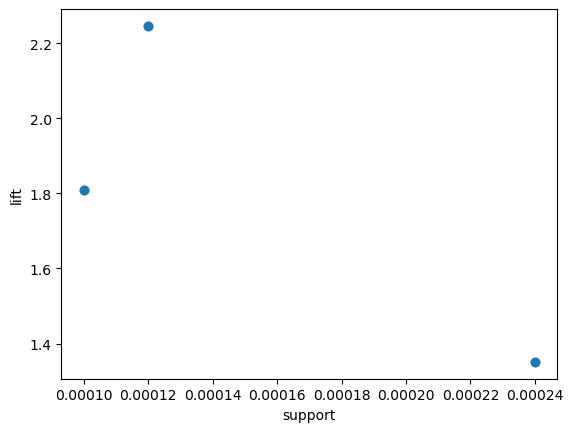

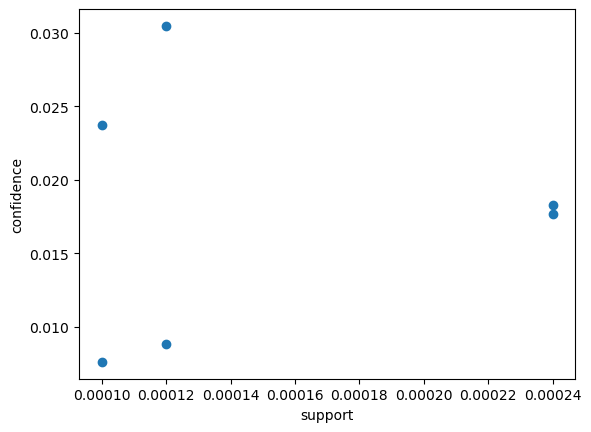

In [38]:

supp = []
lift = []
conf = []
for i in range(len(rules)):
    supp.append(rules[i].support)
    lift.append(rules[i].lift)
    conf.append(rules[i].confidence)
plt.xlabel('support')
plt.ylabel('lift')
plt.scatter(supp,lift)
plt.show()
plt.clf()
plt.xlabel('support')
plt.ylabel('confidence')
plt.scatter(supp,conf)
plt.show()

# 数据集2:新闻数据集
## 频繁模式挖掘

In [44]:

# Initialize the stemmer
stemmer = PorterStemmer()

# Define a function to parse the JSON data and combine "Label" and "Type"
def parse_json(row):
    try:
        # Tokenize the abstract
        tokens = nltk.word_tokenize(row['abstract'])

        # Remove stop words and stem the tokens
        tokens = [stemmer.stem(token) for token in tokens if token not in stopwords.words('english')]

        # Extract keywords from the stemmed tokens
        vectorizer = CountVectorizer(max_features=5)
        X = vectorizer.fit_transform([' '.join(tokens)])
        keywords = vectorizer.get_feature_names_out()

        # Combine keywords with the "category" into a DataFrame
        return pd.DataFrame({'Keyword': keywords, 'Category': [row["category"]] * len(keywords)})
    except:
        return pd.DataFrame()

# Apply the function to the DataFrame and concatenate the results
combined_df = pd.concat(news_df.apply(parse_json, axis=1).tolist(), ignore_index=True)

In [45]:
# Convert data to list of lists for association rule mining
transactions = combined_df.values.tolist()

# Perform frequent pattern mining and generate association rules
itemsets, rules = apriori(transactions, min_support=0.001,  min_confidence=0.1)

# Display frequent itemsets
print("Frequent Itemsets:")
for itemset in itemsets.items():
    print(itemset)

# Display association rules
print("\nAssociation Rules:")
for rule in rules:
    print(rule)

Frequent Itemsets:
(1, {('lifestyle',): 9871, ('news',): 62931, ('health',): 8364, ('help',): 265, ('accord',): 648, ('sports',): 52945, ('it',): 557, ('re',): 272, ('weather',): 6871, ('said',): 1026, ('sunday',): 298, ('entertainment',): 2594, ('expect',): 215, ('game',): 866, ('foodanddrink',): 10689, ('autos',): 6602, ('2019',): 633, ('after',): 304, ('go',): 323, ('announc',): 290, ('compani',): 263, ('around',): 483, ('know',): 220, ('the',): 3180, ('back',): 686, ('look',): 426, ('travel',): 8738, ('last',): 305, ('video',): 8071, ('famili',): 300, ('home',): 485, ('food',): 214, ('good',): 226, ('chang',): 310, ('make',): 396, ('best',): 533, ('tv',): 4049, ('even',): 246, ('find',): 262, ('injuri',): 200, ('11',): 258, ('peopl',): 286, ('report',): 392, ('state',): 697, ('10',): 522, ('across',): 251, ('fan',): 204, ('high',): 284, ('2020',): 460, ('time',): 437, ('coach',): 393, ('show',): 226, ('finance',): 12525, ('could',): 535, ('hous',): 378, ('year',): 576, ('one',): 65

## 模式命名
新闻关键词和类型对应模式
## 结果分析

In [46]:

ap = list(apyori.apriori(transactions, min_support=0.0001, min_confidence=0, min_lift=0))
supports = []
confidences = []
lifts = []
bases = []
adds = []

for r in ap:
    for x in r.ordered_statistics:
        supports.append(r.support)
        confidences.append(x.confidence)
        lifts.append(x.lift)
        bases.append(list(x.items_base))
        adds.append(list(x.items_add))

result = pd.DataFrame({
    'support':supports,
    'confidence':confidences,
    'lift':lifts,
    'base':bases,
    'add':adds
})

res = result[(result.lift > 0.0) & (result.support > 0.1) & (result.confidence > 0.1)]
res = res.reset_index(drop=True)
print('*'*32)
print('results of package apyori')
print('*'*32)
print(res)

print('*'*32)
print('results of package efficient_apyori')
print('*'*32)
for i in range(len(rules)):
    print(rules[i])

********************************
results of package apyori
********************************
    support  confidence  lift base       add
0  0.315819    0.315819   1.0   []    [news]
1  0.265704    0.265704   1.0   []  [sports]
********************************
results of package efficient_apyori
********************************
{000} -> {news} (conf: 0.433, supp: 0.001, lift: 1.373, conv: 1.208)
{2019} -> {sports} (conf: 0.502, supp: 0.002, lift: 1.891, conv: 1.476)
{accord} -> {news} (conf: 0.500, supp: 0.002, lift: 1.583, conv: 1.368)
{arrest} -> {news} (conf: 0.755, supp: 0.001, lift: 2.390, conv: 2.789)
{back} -> {sports} (conf: 0.509, supp: 0.002, lift: 1.915, conv: 1.495)
{brown} -> {sports} (conf: 0.770, supp: 0.001, lift: 2.898, conv: 3.193)
{charg} -> {news} (conf: 0.775, supp: 0.001, lift: 2.454, conv: 3.043)
{citi} -> {news} (conf: 0.442, supp: 0.002, lift: 1.399, conv: 1.226)
{coach} -> {sports} (conf: 0.924, supp: 0.002, lift: 3.476, conv: 9.619)
{counti} -> {news} (conf: 0

可以看出，我们找出了几条强关联规则。这些意味着新闻中的关键词与新闻的类别有相关性。可以对新闻分类和推荐（结合上一个数据集）提供指导。

## 可视化

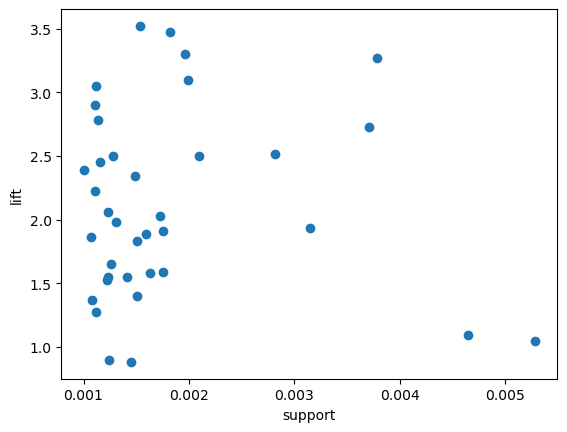

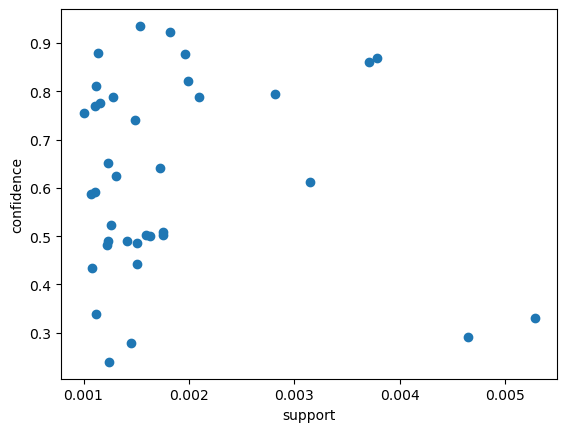

In [47]:
supp = []
lift = []
conf = []
for i in range(len(rules)):
    supp.append(rules[i].support)
    lift.append(rules[i].lift)
    conf.append(rules[i].confidence)
plt.xlabel('support')
plt.ylabel('lift')
plt.scatter(supp,lift)
plt.show()
plt.clf()
plt.xlabel('support')
plt.ylabel('confidence')
plt.scatter(supp,conf)
plt.show()